# [これ](https://mori-memo.hateblo.jp/entry/2022/10/16/173011)見てやり直すか...

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# ディレクトリの移動
%cd drive/MyDrive/nlp100
%pwd

Mounted at /content/drive
/content/drive/MyDrive/nlp100


'/content/drive/MyDrive/nlp100'

In [2]:
import gc

gc.enable()
print(gc.isenabled)

<built-in function isenabled>


In [3]:
CATEGORY_DICT = {"b" : 0, "t" : 1, "e": 2, "m" : 3}
CUT_THRESHOLD_FOR_MEMORY = 200
SHUFFLE = False

## 80. ID番号への変換
問題51で構築した学習データ中の単語にユニークなID番号を付与したい．学習データ中で最も頻出する単語に1，2番目に頻出する単語に2，……といった方法で，学習データ中で2回以上出現する単語にID番号を付与せよ．そして，与えられた単語列に対して，ID番号の列を返す関数を実装せよ．ただし，出現頻度が2回未満の単語のID番号はすべて0とせよ．

In [4]:
# 問題51ではtfidfを使ったのに対して、ここで要求されていることが割と違うため、データを作り直す
import pandas as pd
from collections import defaultdict

df_train = pd.read_csv("./NewsAggregatorDataset/train.csv", sep="\t")
df_valid = pd.read_csv("./NewsAggregatorDataset/valid.csv", sep="\t")
df_test = pd.read_csv("./NewsAggregatorDataset/test.csv", sep="\t")

titles_train = df_train["TITLE"]
titles_valid = df_valid["TITLE"]
titles_test = df_test["TITLE"]

titles_train = titles_train[:CUT_THRESHOLD_FOR_MEMORY]

word_count_dict_train = defaultdict(int)
for title in titles_train:
    title_word_list = title.split()
    for word in title_word_list:
        word_count_dict_train[word] += 1
print(word_count_dict_train)

sorted_word_count_dict = sorted(word_count_dict_train.items(), key=lambda x: x[1],reverse=True)
print(sorted_word_count_dict)

word_count_dict_valid = defaultdict(int)
for title in titles_valid:
    title_word_list = title.split()
    for word in title_word_list:
        word_count_dict_valid[word] += 1
print(word_count_dict_valid)

sorted_word_count_dict_valid = sorted(word_count_dict_valid.items(), key=lambda x: x[1],reverse=True)
print(sorted_word_count_dict_valid)

word_rank_dict = defaultdict(int)
for index, content in enumerate(sorted_word_count_dict):
    if content[1] < 2: #2回未満の単語のidはすべて0とする
        word_rank_dict[content[0]] = 0
    else:
        word_rank_dict[content[0]] = index+1
print(word_rank_dict)

# word_rank_dict_valid = defaultdict(int)
# for index, content in enumerate(sorted_word_count_dict_valid):
#     if content[1] < 2: #2回未満の単語のidはすべて0とする
#         word_rank_dict_valid[content[0]] = 0
#     else:
#         word_rank_dict_valid[content[0]] = index+1
# print(word_rank_dict_valid)

defaultdict(<class 'int'>, {'David': 3, 'McNew': 1, 'via': 1, 'Getty': 1, 'Images': 1, 'Barclays': 3, 'Will': 3, 'Post': 1, 'Small': 1, 'Decline': 2, 'in': 20, 'First-Quarter': 1, 'Profit': 3, '(1)': 4, 'Euro': 1, 'Anxieties': 1, 'Wane': 1, 'as': 26, 'Bunds': 1, 'Top': 3, 'Treasuries,': 1, 'Spain': 1, 'Debt': 1, 'Rallies': 1, 'Etihad': 1, "Airways'": 1, 'New': 10, 'Plane': 1, 'Design': 1, 'Takes': 1, 'Luxury': 1, 'To': 11, 'Heights': 1, 'Neil': 2, 'deGrasse': 1, 'Tyson': 1, 'Talks': 1, 'Asteroids': 1, 'With': 8, '9-Year-Old': 1, 'Boy': 1, 'In': 10, 'Michigan': 1, 'US': 16, 'announces': 1, 'funding': 1, 'to': 40, 'fight': 1, 'citrus': 1, 'greening': 1, 'disease': 2, 'Smartphone': 1, 'Industry': 1, 'Promises': 1, "'Kill": 1, "Switch'": 1, 'Reduce': 1, 'Thefts': 1, 'Comcast': 2, 'Turns': 1, 'Back': 2, 'Cord-Cutting': 1, 'Tide,': 1, 'Adds': 1, 'Video': 1, 'Customers': 1, 'UK': 1, 'Services': 1, 'Grow': 1, 'More': 2, 'Than': 2, 'Forecast': 1, 'Employment': 1, 'Picks': 1, 'Up': 4, 'Miley': 4

In [5]:
def words_to_ids(words):
    words = words.split()
    ids = [word_rank_dict[word] for word in words]
    return ids

In [6]:
# print(words_to_ids(titles_train[0]))
# print(words_to_ids(titles_train[1]))

## 81. RNNによる予測
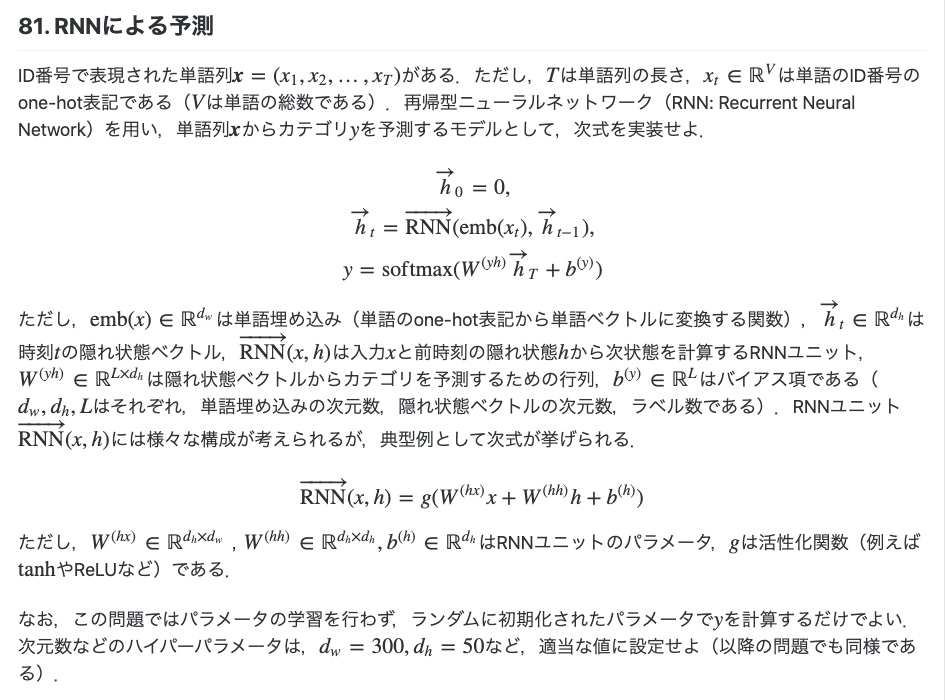

- 単語列からカテゴリを予測するRNNモデル
- $emb(x)$は単語埋め込み。単語のone-hotから単語ベクトルに変換する関数
    - $x_t$は「単語列」ではなく「単語（のID番号）」
    - $x_t$は単語のidのone-hot表記
        - one-hotにするのを諦めた...
        - $x_t$は単語idの配列とする。

In [7]:
import torch
from torch import nn, optim

MAX_ID = max(word_rank_dict.values())

dw = 300 #単語埋め込みの次元数
dh = 50 #隠れ常態ベクトルの次元数
LABEL_NUM = 4

max_length = max(len(lst) for lst in titles_train)
max_length_valid = max(len(lst) for lst in titles_train)

print(max_length)

list_to_append = [0] * MAX_ID

titles_train_id_list = []
titles_valid_id_list = []

for title in titles_train:
    ids = words_to_ids(title)
    titles_train_id_list.append(ids)
for title in titles_valid:
    ids = words_to_ids(title)
    titles_valid_id_list.append(ids)

print(titles_train_id_list)
# 各リストの長さをmax_lengthに揃える
for i in range(len(titles_train)):
    while len(titles_train_id_list[i]) < max_length:
        titles_train_id_list[i].append(0)
for i in range(len(titles_valid)):
    while len(titles_valid_id_list[i]) < max_length_valid:
        titles_valid_id_list[i].append(0)

print(MAX_ID)



88
[[47, 0, 0, 0, 0], [48, 49, 0, 0, 90, 5, 0, 50, 34], [0, 0, 0, 3, 0, 51, 0, 0, 0, 0], [0, 0, 14, 0, 0, 0, 0, 13, 14, 0], [91, 0, 0, 0, 0, 18, 0, 0, 15, 0], [9, 0, 0, 1, 0, 0, 0, 92], [0, 0, 0, 0, 0, 13, 0, 0], [93, 0, 94, 0, 0, 0, 14, 0, 0], [0, 0, 0, 95, 96, 0, 3, 0, 0, 35], [36, 52, 0, 0, 35, 0, 0, 0, 0, 0], [0, 5, 0, 0, 0, 0, 97, 53, 0, 0, 1, 7, 0, 0, 2], [0, 54, 55, 98, 37, 38, 99, 0, 16, 0, 0], [100, 56, 57, 58, 0, 101, 0, 18, 59], [48, 0, 0, 102, 1, 0, 0, 0], [60, 25, 103, 0, 0, 104, 0, 0, 0, 0, 20, 0, 2], [0, 0, 0, 105, 61, 21, 0, 10, 7, 0, 0], [0, 0, 0, 0, 0, 0, 106], [0, 0, 107, 62, 63, 0], [9, 0, 108, 0, 1, 39, 17, 0, 26], [4, 0, 0, 0, 64, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 109], [4, 0, 0, 0, 8, 0, 0, 100, 65], [0, 54, 55, 0, 0, 0, 0, 16, 93, 0], [0, 66, 0, 40, 110, 0, 10, 67], [111, 0, 0, 0, 0, 18, 22, 0, 0, 27, 0], [0, 101, 50, 112, 68, 113, 114, 0, 34], [36, 52, 115, 53, 7, 0, 0, 6, 0, 69, 116, 19, 23, 0, 0], [70, 0, 8, 0, 0, 11, 0, 10, 7, 0, 0, 0, 0, 54, 0], [0, 0, 0, 

In [8]:
class RNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, hidden_size, output_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.emb = nn.Embedding(vocab_size, emb_size)
        self.rnn = nn.RNN(emb_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        x = self.emb(x)
        x, h = self.rnn(x, h0)
        x = x[:, -1, :]
        logits = self.fc(x)
        logits  =self.softmax(logits)
        return logits

## 82. 確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題81で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

In [9]:
BATCH_SIZE = 1

In [10]:
print(titles_train_id_list[94])

[197, 198, 12, 0, 197, 198, 0, 28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [11]:
for one in titles_train_id_list:
    print(len(one))

88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88
88


In [12]:
import numpy as np

X_train = np.array(titles_train_id_list)
print(X_train)
print(type(X_train))
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(df_train["CATEGORY"].map(CATEGORY_DICT).tolist()[:CUT_THRESHOLD_FOR_MEMORY])
print(X_train.shape)
print(y_train.shape)
dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=2)

X_valid = np.array(titles_valid_id_list)
print(X_valid)
print(type(X_valid))
X_valid = torch.tensor(X_valid, dtype=torch.long)
y_valid = torch.tensor(df_valid["CATEGORY"].map(CATEGORY_DICT).tolist())
print(X_valid.shape)
print(y_valid.shape)
dataset_valid = torch.utils.data.TensorDataset(X_valid, y_valid)
dataloader_valid = torch.utils.data.DataLoader(dataset=dataset_valid, batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=2)

[[ 47   0   0 ...   0   0   0]
 [ 48  49   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [206   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0  12 ...   0   0   0]]
<class 'numpy.ndarray'>
torch.Size([200, 88])
torch.Size([200])
[[42  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [11  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0 17 ...  0  0  0]
 [11  0 30 ...  0  0  0]]
<class 'numpy.ndarray'>
torch.Size([1334, 88])
torch.Size([1334])


In [14]:
dataloader_dict = {"train" : dataloader_train, "valid" : dataloader_valid}

In [16]:
from sklearn.metrics import accuracy_score

# パラメータの設定
# VOCAB_SIZE = MAX_ID + 2  # 辞書のID数 + unknown + パディングID
VOCAB_SIZE = MAX_ID + 2
EMB_SIZE = 300
PADDING_IDX = MAX_ID + 1
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 100

EPOCH_NUM = 10

model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS)
optimizer = torch.optim.SGD(model.parameters(), 0.01)
loss_fn = torch.nn.CrossEntropyLoss()

import matplotlib.pyplot as plt
from tqdm import tqdm

# 学習用の関数を定義
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []
    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {} / {}'.format(epoch + 1, num_epochs))
        print('--------------------------------------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'valid']:
            if phase == 'train':
                net.train() # 訓練モード
            else:
                net.eval() # 検証モード

            epoch_loss = 0.0 # epochの損失和
            epoch_corrects = 0 # epochの正解数

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                optimizer.zero_grad() # optimizerを初期化

                # 順伝播計算(forward)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels) # 損失を計算
                    _, preds = torch.max(outputs, 1) # ラベルを予想

                    # 訓練時は逆伝播
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イテレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率の表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)

            print('{} Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    return train_loss, train_acc, valid_loss, valid_acc

# 学習を実行する

# モデルの定義
net = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS)
net.train()

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

num_epochs = 5
train_loss, train_acc, valid_loss, valid_acc = train_model(net,
            dataloader_dict, criterion, optimizer, num_epochs=num_epochs)

# def train():
#     train_loss = 0
#     train_acc = 0
#     data_length = 0

#     y_true = []
#     y_pred = []
#     for idx, (x, y) in enumerate(dataloader_train):
#         optimizer.zero_grad()
#         data_length += 1
#         # print("=========")
#         # print("idx : {}".format(idx))
#         pred_logits = model(x)
#         loss = loss_fn(pred_logits, y)
#         pred_label = pred_logits.argmax(dim=1)
#         y_true.append(y.item())
#         y_pred.append(pred_label.item())
#         # print("y: {}, pred_label: {}".format(y, pred_label))
#         acc = accuracy_score(y, pred_label)
#         loss.backward()
#         train_loss += loss.item()
#         train_acc += acc #ここ書き直したい sklearnで
#         optimizer.step()

#     print("loss : {:>10}".format(train_loss / data_length))
#     print("accuracy : {:>10}".format(accuracy_score(y_true, y_pred)))
#     print("y_true : {}".format(y_true))
#     print("y_pred : {}".format(y_pred))

# for epoch in range(EPOCH_NUM):
#     print("========== epoch {}============".format(epoch+1))
#     train()

Epoch 1 / 5
--------------------------------------------


100%|██████████| 200/200 [00:03<00:00, 59.31it/s]


train Loss: 1.1537, Acc: 0.4800


100%|██████████| 1334/1334 [00:04<00:00, 272.01it/s]


valid Loss: 1.1613, Acc: 0.4235
Epoch 2 / 5
--------------------------------------------


100%|██████████| 200/200 [00:05<00:00, 38.48it/s]


train Loss: 1.1466, Acc: 0.4950


100%|██████████| 1334/1334 [00:05<00:00, 244.67it/s]


valid Loss: 1.1605, Acc: 0.3988
Epoch 3 / 5
--------------------------------------------


100%|██████████| 200/200 [00:03<00:00, 63.07it/s]


train Loss: 1.1406, Acc: 0.4950


100%|██████████| 1334/1334 [00:06<00:00, 217.72it/s]


valid Loss: 1.1603, Acc: 0.3988
Epoch 4 / 5
--------------------------------------------


100%|██████████| 200/200 [00:02<00:00, 69.83it/s]


train Loss: 1.1368, Acc: 0.4850


100%|██████████| 1334/1334 [00:04<00:00, 268.01it/s]


valid Loss: 1.1600, Acc: 0.3988
Epoch 5 / 5
--------------------------------------------


100%|██████████| 200/200 [00:03<00:00, 60.22it/s]


train Loss: 1.1341, Acc: 0.4950


100%|██████████| 1334/1334 [00:05<00:00, 240.90it/s]

valid Loss: 1.1596, Acc: 0.3988


## 83. ミニバッチ化・GPU上での学習
問題82のコードを改変し，B
事例ごとに損失・勾配を計算して学習を行えるようにせよ（B
の値は適当に選べ）．また，GPU上で学習を実行せよ

In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, hidden_size, output_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.emb = nn.Embedding(vocab_size, emb_size)
        self.rnn = nn.RNN(emb_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)  #0番目の隠れ層もcudaに移す必要がある
        x = self.emb(x)
        x, h = self.rnn(x, h0)
        x = x[:, -1, :]
        logits = self.fc(x)
        logits  =self.softmax(logits)
        return logits

In [ ]:
from sklearn.metrics import accuracy_score
import itertools

import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 10

# パラメータの設定
VOCAB_SIZE = MAX_ID + 2  # 辞書のID数 + unknown + パディングID
VOCAB_SIZE_valid = MAX_ID + 2  # 辞書のID数 + unknown + パディングID

EMB_SIZE = 300
PADDING_IDX = MAX_ID + 1
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 3

EPOCH_NUM = 100

model = RNN(max(VOCAB_SIZE, VOCAB_SIZE_valid), EMB_SIZE, PADDING_IDX, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), 0.01)
loss_fn = torch.nn.CrossEntropyLoss()

def train():
    train_loss = 0
    train_acc = 0
    data_length = 0

    y_true = []
    y_pred = []
    for idx, (x, y) in enumerate(dataloader_train):
        x = x.to(device)
        y = y.to(device)
        data_length += 1
        optimizer.zero_grad()
        pred_logits = model(x)
        loss = loss_fn(pred_logits, y)
        pred_label = pred_logits.argmax(dim=1)
        y_true.append(y.tolist())
        y_pred.append(pred_label.tolist())
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    y_true = list(itertools.chain(*y_true))
    y_pred = list(itertools.chain(*y_pred))
    print("loss : {:>10}".format(train_loss / data_length))
    print("accuracy : {:>10}".format(accuracy_score(y_true, y_pred)))
    print("y_true (train): {}".format(y_true))
    print("y_pred (train): {}".format(y_pred))

def valid():
    with torch.no_grad():
        data_length = 0
        y_true = []
        y_pred = []
        for idx, (x, y) in enumerate(dataloader_valid):
            x = x.to(device)
            y = y.to(device)
            data_length += 1
            optimizer.zero_grad()
            pred_logits = model(x)
            pred_label = pred_logits.argmax(dim=1)
            y_true.append(y.tolist())
            y_pred.append(pred_label.tolist())
        y_true = list(itertools.chain(*y_true))
        y_pred = list(itertools.chain(*y_pred))
        print("accuracy(valid) : {:>10}".format(accuracy_score(y_true, y_pred)))
        print("y_true (valid): {}".format(y_true))
        print("y_pred (valid): {}".format(y_pred))


for epoch in range(EPOCH_NUM):
    print("========== epoch {}============".format(epoch+1))
    train()
    valid()